Loading GoEmotions Model from Hugging Face...


Device set to use cuda:0


Model loaded successfully on device: 0
Model Name: SamLowe/roberta-base-go_emotions
Direct download link: https://huggingface.co/SamLowe/roberta-base-go_emotions

RESEARCH SETUP COMPLETE
Total emotion categories: 5
  - Happy: 5 prompts
  - Sad: 5 prompts
  - Angry: 5 prompts
  - Neutral: 5 prompts
  - Mixed: 5 prompts

STARTING EMOTIONAL ALIGNMENT & BEHAVIOURAL DRIFT EXPERIMENT


TESTING CATEGORY: HAPPY

[Prompt 1] Today was absolutely wonderful! I just got promoted at work!...
  Repeat 1: admiration(0.43), joy(0.40), excitement(0.40)
  Repeat 2: admiration(0.43), joy(0.40), excitement(0.40)
  Repeat 3: admiration(0.43), joy(0.40), excitement(0.40)

[Prompt 2] I'm so thrilled about the new opportunities coming my way....
  Repeat 1: excitement(0.78), joy(0.28), neutral(0.03)
  Repeat 2: excitement(0.78), joy(0.28), neutral(0.03)
  Repeat 3: excitement(0.78), joy(0.28), neutral(0.03)

[Prompt 3] Everything is going perfectly and I couldn't be happier!...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Repeat 1: joy(0.68), approval(0.21), admiration(0.10)
  Repeat 2: joy(0.68), approval(0.21), admiration(0.10)
  Repeat 3: joy(0.68), approval(0.21), admiration(0.10)


TESTING CATEGORY: SAD

[Prompt 1] I'm feeling really down and hopeless about everything....
  Repeat 1: disappointment(0.54), sadness(0.38), annoyance(0.06)
  Repeat 2: disappointment(0.54), sadness(0.38), annoyance(0.06)
  Repeat 3: disappointment(0.54), sadness(0.38), annoyance(0.06)

[Prompt 2] Nothing seems to matter anymore, I'm deeply sad....
  Repeat 1: sadness(0.91), disappointment(0.08), grief(0.03)
  Repeat 2: sadness(0.91), disappointment(0.08), grief(0.03)
  Repeat 3: sadness(0.91), disappointment(0.08), grief(0.03)

[Prompt 3] This loss has broken my heart completely....
  Repeat 1: sadness(0.90), disappointment(0.14), grief(0.03)
  Repeat 2: sadness(0.90), disappointment(0.14), grief(0.03)
  Repeat 3: sadness(0.90), disappointment(0.14), grief(0.03)


TESTING CATEGORY: ANGRY

[Prompt 1] I'm absolutely fur

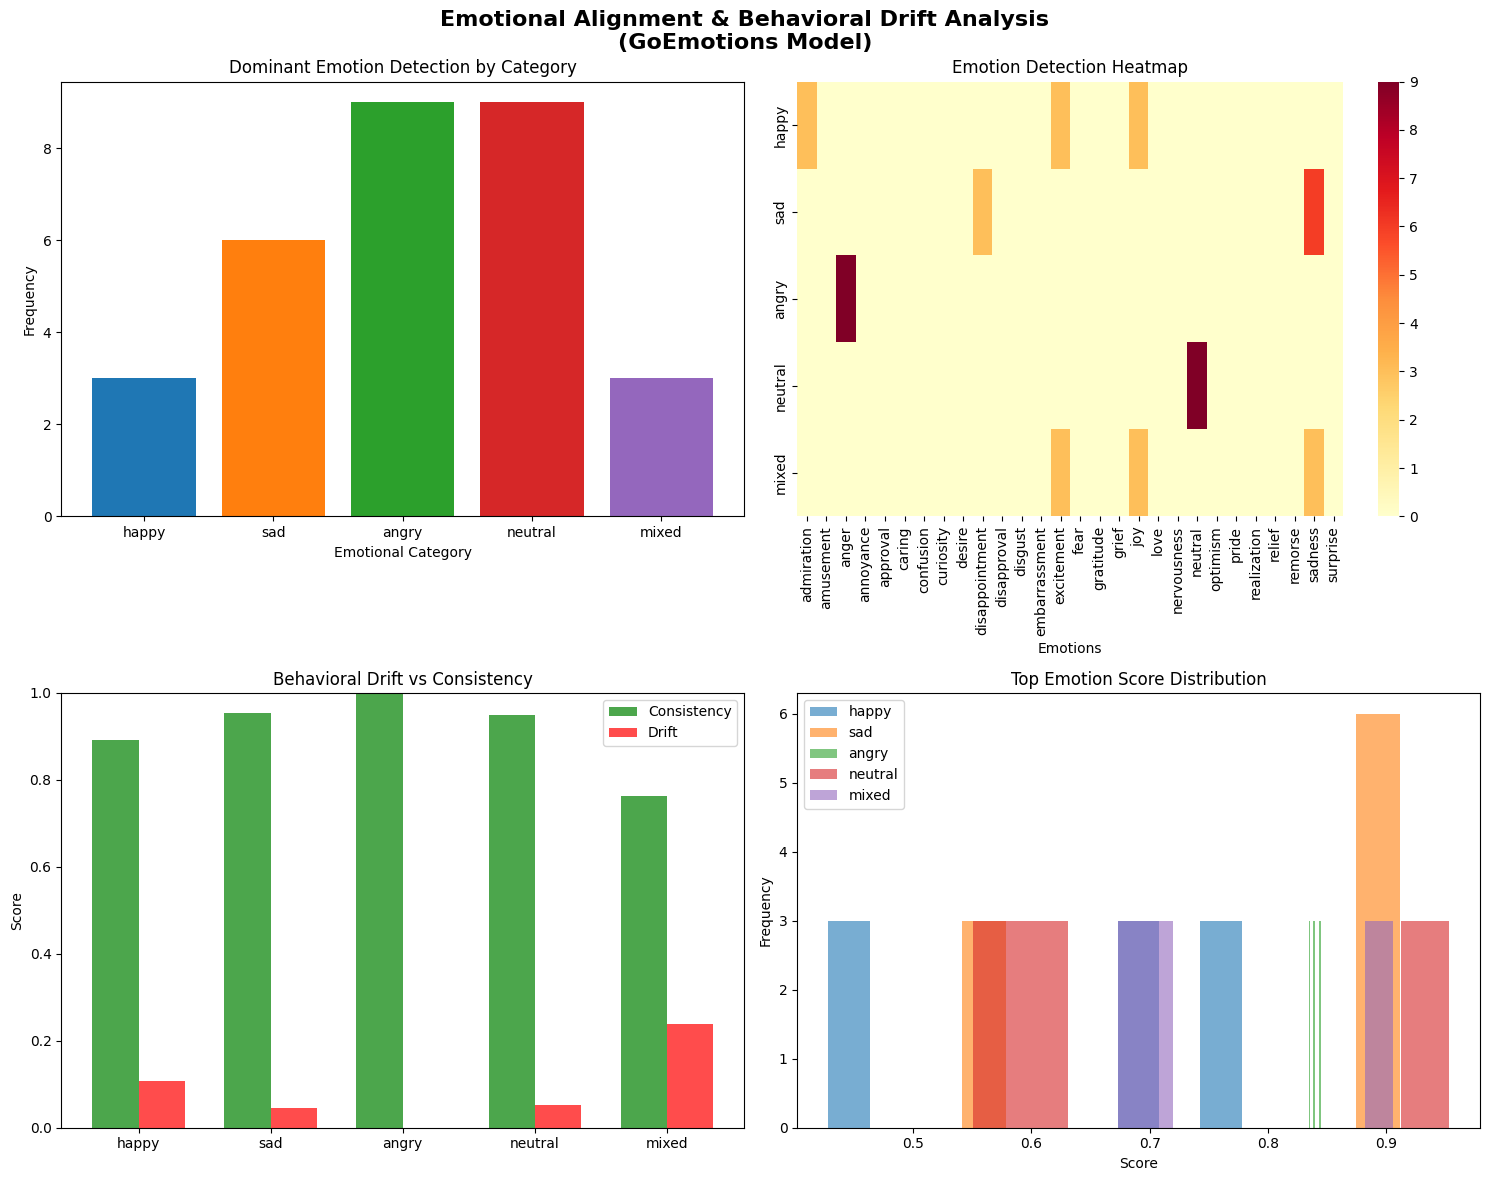

✓ Detailed results saved to 'emotion_research_results.csv'

RESEARCH SUMMARY
Total Prompts Tested: 5
Total Samples Processed: 45
Unique Emotions Detected: 28
All Detected Emotions: admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, neutral, optimism, pride, realization, relief, remorse, sadness, surprise

CONSISTENCY & DRIFT SUMMARY TABLE
category  samples  consistency    drift  std_deviation  avg_top_score
   happy        9     0.891518 0.108482       0.205803       0.627967
     sad        9     0.953860 0.046140       0.120986       0.782978
   angry        9     0.999496 0.000504       0.001170       0.839076
 neutral        9     0.948382 0.051618       0.089489       0.698196
   mixed        9     0.761951 0.238049       0.412527       0.762527

RESEARCH COMPLETE!
Files generated:
  1. emotional_alignment_analysis.png - Visualizati

In [1]:
# Install required libraries
!pip install transformers torch pandas numpy matplotlib seaborn scikit-learn scipy openpyxl -q

# Imports
import torch
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine, pdist, squareform
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import normalize
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# PART 1: SETUP - Load GoEmotions Model
# ============================================================================

print("Loading GoEmotions Model from Hugging Face...")
device = 0 if torch.cuda.is_available() else -1

# Direct link to download: https://huggingface.co/SamLowe/roberta-base-go_emotions
model_name = "SamLowe/roberta-base-go_emotions"
classifier = pipeline(
    task="text-classification",
    model=model_name,
    top_k=None,
    device=device
)

print(f"Model loaded successfully on device: {device}")
print(f"Model Name: {model_name}")
print(f"Direct download link: https://huggingface.co/{model_name}")

# ============================================================================
# PART 2: EMOTION PROMPTS - Generate Test Prompts
# ============================================================================

# Define prompts for different emotional contexts
emotional_prompts = {
    "happy": [
        "Today was absolutely wonderful! I just got promoted at work!",
        "I'm so thrilled about the new opportunities coming my way.",
        "Everything is going perfectly and I couldn't be happier!",
        "This is the best day ever, I'm feeling fantastic!",
        "I'm delighted with all the positive changes happening.",
    ],
    "sad": [
        "I'm feeling really down and hopeless about everything.",
        "Nothing seems to matter anymore, I'm deeply sad.",
        "This loss has broken my heart completely.",
        "I'm struggling with overwhelming sadness right now.",
        "Everything feels empty and meaningless.",
    ],
    "angry": [
        "I'm absolutely furious about this unfair situation!",
        "This makes me so angry I can barely contain myself.",
        "I'm enraged by how disrespectfully I've been treated.",
        "This injustice fills me with intense rage.",
        "I'm angry and frustrated beyond belief.",
    ],
    "neutral": [
        "The weather today is partly cloudy with a chance of rain.",
        "I need to schedule a meeting for next Tuesday.",
        "The report contains data from the fiscal year 2024.",
        "That's a factual statement about the matter.",
        "The temperature outside is around 25 degrees Celsius.",
    ],
    "mixed": [
        "I'm happy but also slightly worried about the future.",
        "It's sad that good things always come to an end.",
        "I'm excited yet nervous about starting this new job.",
        "This situation is both frustrating and motivating.",
        "I'm grateful but also disappointed.",
    ]
}

print("\n" + "="*80)
print("RESEARCH SETUP COMPLETE")
print("="*80)
print(f"Total emotion categories: {len(emotional_prompts)}")
for category, prompts in emotional_prompts.items():
    print(f"  - {category.capitalize()}: {len(prompts)} prompts")

# ============================================================================
# PART 3: EMOTION DETECTION FUNCTION
# ============================================================================

def get_emotion_scores(text, threshold=0.5):
    """
    Get emotion scores for a given text using GoEmotions model.
    Returns emotions above threshold.
    """
    try:
        results = classifier(text)
        if isinstance(results, list) and len(results) > 0:
            # Filter by threshold and extract scores
            emotions = {}
            for item in results[0]:
                if item['score'] >= threshold:
                    emotions[item['label']] = item['score']
            return emotions
        return {}
    except Exception as e:
        print(f"Error processing text: {e}")
        return {}

def get_all_emotion_scores(text):
    """
    Get all emotion scores (no threshold filtering).
    Returns dict of all 28 emotions with scores.
    """
    try:
        results = classifier(text)
        if isinstance(results, list) and len(results) > 0:
            emotions = {}
            for item in results[0]:
                emotions[item['label']] = item['score']
            return emotions
        return {}
    except Exception as e:
        print(f"Error processing text: {e}")
        return {}

# ============================================================================
# PART 4: MAIN RESEARCH EXPERIMENT
# ============================================================================

class EmotionalAlignmentStudy:
    def __init__(self, model_name, sample_prompts=3, repeats=3):
        self.model_name = model_name
        self.sample_prompts = sample_prompts
        self.repeats = repeats
        self.results = []
        self.all_emotions = set()

    def run_experiment(self):
        """Run the complete emotional alignment experiment."""
        print("\n" + "="*80)
        print("STARTING EMOTIONAL ALIGNMENT & BEHAVIOURAL DRIFT EXPERIMENT")
        print("="*80)

        for category, prompts in emotional_prompts.items():
            print(f"\n\n{'='*80}")
            print(f"TESTING CATEGORY: {category.upper()}")
            print(f"{'='*80}")

            # Select sample prompts
            selected_prompts = prompts[:self.sample_prompts]

            for prompt_idx, prompt in enumerate(selected_prompts, 1):
                print(f"\n[Prompt {prompt_idx}] {prompt[:60]}...")

                # Repeat the same prompt multiple times to detect drift
                for repeat in range(self.repeats):
                    timestamp = datetime.now().isoformat()

                    # Get emotion scores
                    emotions = get_all_emotion_scores(prompt)

                    # Store results
                    self.results.append({
                        'timestamp': timestamp,
                        'category': category,
                        'prompt_text': prompt,
                        'prompt_index': prompt_idx,
                        'repeat_number': repeat + 1,
                        'emotions': emotions,
                        'top_emotion': max(emotions, key=emotions.get) if emotions else 'unknown',
                        'top_score': max(emotions.values()) if emotions else 0
                    })

                    # Collect all emotion labels
                    self.all_emotions.update(emotions.keys())

                    # Print top emotions
                    sorted_emotions = sorted(emotions.items(), key=lambda x: x[1], reverse=True)[:3]
                    print(f"  Repeat {repeat + 1}: {', '.join([f'{e[0]}({e[1]:.2f})' for e in sorted_emotions])}")

        print("\n" + "="*80)
        print("EXPERIMENT COMPLETED")
        print("="*80)
        print(f"Total samples processed: {len(self.results)}")
        print(f"Unique emotions detected: {len(self.all_emotions)}")

        return self.results

    def calculate_consistency_metrics(self):
        """Calculate behavioral drift and consistency metrics."""
        print("\n" + "="*80)
        print("CALCULATING CONSISTENCY & DRIFT METRICS")
        print("="*80)

        consistency_data = []

        for category in emotional_prompts.keys():
            category_results = [r for r in self.results if r['category'] == category]

            if len(category_results) < 2:
                continue

            # Extract emotion vectors
            emotion_vectors = []
            for result in category_results:
                vector = np.array([result['emotions'].get(e, 0) for e in sorted(self.all_emotions)])
                emotion_vectors.append(vector)

            emotion_vectors = np.array(emotion_vectors)

            # Calculate consistency (inverse of drift)
            if len(emotion_vectors) > 1:
                # Pairwise cosine similarity
                similarities = []
                for i in range(len(emotion_vectors)-1):
                    sim = 1 - cosine(emotion_vectors[i], emotion_vectors[i+1])
                    similarities.append(sim)

                consistency = np.mean(similarities) if similarities else 0
                drift = 1 - consistency
                std_dev = np.std(similarities) if similarities else 0
            else:
                consistency = 1.0
                drift = 0.0
                std_dev = 0.0

            consistency_data.append({
                'category': category,
                'samples': len(category_results),
                'consistency': consistency,
                'drift': drift,
                'std_deviation': std_dev,
                'avg_top_score': np.mean([r['top_score'] for r in category_results])
            })

            print(f"\n{category.upper()}:")
            print(f"  Consistency Score: {consistency:.4f}")
            print(f"  Behavioural Drift: {drift:.4f}")
            print(f"  Std Deviation: {std_dev:.4f}")
            print(f"  Avg Top Emotion Score: {np.mean([r['top_score'] for r in category_results]):.4f}")

        return consistency_data

    def create_visualizations(self):
        """Create visualizations for the research."""
        print("\n" + "="*80)
        print("GENERATING VISUALIZATIONS")
        print("="*80)

        # Prepare data
        categories = list(emotional_prompts.keys())
        category_top_emotions = defaultdict(lambda: defaultdict(float))
        category_consistency = defaultdict(float)

        for result in self.results:
            cat = result['category']
            top_em = result['top_emotion']
            category_top_emotions[cat][top_em] += 1

        # Create figure
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Emotional Alignment & Behavioral Drift Analysis\n(GoEmotions Model)',
                     fontsize=16, fontweight='bold')

        # Plot 1: Top Emotions by Category
        ax1 = axes[0, 0]
        for category in categories:
            emotions_count = category_top_emotions[category]
            if emotions_count:
                top_emotion = max(emotions_count, key=emotions_count.get)
                ax1.bar(category, emotions_count[top_emotion], label=top_emotion)
        ax1.set_title('Dominant Emotion Detection by Category')
        ax1.set_ylabel('Frequency')
        ax1.set_xlabel('Emotional Category')

        # Plot 2: Emotion Distribution Heatmap
        ax2 = axes[0, 1]
        emotion_matrix = []
        for category in categories:
            category_results = [r for r in self.results if r['category'] == category]
            emotion_counts = defaultdict(int)
            for result in category_results:
                top_em = result['top_emotion']
                emotion_counts[top_em] += 1
            emotion_matrix.append([emotion_counts.get(e, 0) for e in sorted(self.all_emotions)])

        sns.heatmap(emotion_matrix, xticklabels=sorted(self.all_emotions),
                    yticklabels=categories, ax=ax2, cmap='YlOrRd')
        ax2.set_title('Emotion Detection Heatmap')
        ax2.set_xlabel('Emotions')

        # Plot 3: Consistency Metrics
        ax3 = axes[1, 0]
        consistency_scores = self.calculate_consistency_metrics()
        cats = [c['category'] for c in consistency_scores]
        consistency = [c['consistency'] for c in consistency_scores]
        drift = [c['drift'] for c in consistency_scores]

        x = np.arange(len(cats))
        width = 0.35
        ax3.bar(x - width/2, consistency, width, label='Consistency', color='green', alpha=0.7)
        ax3.bar(x + width/2, drift, width, label='Drift', color='red', alpha=0.7)
        ax3.set_ylabel('Score')
        ax3.set_title('Behavioral Drift vs Consistency')
        ax3.set_xticks(x)
        ax3.set_xticklabels(cats)
        ax3.legend()
        ax3.set_ylim([0, 1])

        # Plot 4: Top Score Distribution
        ax4 = axes[1, 1]
        for category in categories:
            category_results = [r for r in self.results if r['category'] == category]
            scores = [r['top_score'] for r in category_results]
            ax4.hist(scores, alpha=0.6, label=category, bins=10)
        ax4.set_title('Top Emotion Score Distribution')
        ax4.set_xlabel('Score')
        ax4.set_ylabel('Frequency')
        ax4.legend()

        plt.tight_layout()
        plt.savefig('emotional_alignment_analysis.png', dpi=300, bbox_inches='tight')
        print("✓ Visualization saved as 'emotional_alignment_analysis.png'")
        plt.show()

    def save_results_to_csv(self, filename='emotion_research_results.csv'):
        """Save detailed results to CSV."""
        df_data = []
        for result in self.results:
            row = {
                'timestamp': result['timestamp'],
                'category': result['category'],
                'prompt_text': result['prompt_text'],
                'prompt_index': result['prompt_index'],
                'repeat_number': result['repeat_number'],
                'top_emotion': result['top_emotion'],
                'top_score': result['top_score'],
            }
            # Add individual emotion scores
            for emotion in sorted(self.all_emotions):
                row[f'emotion_{emotion}'] = result['emotions'].get(emotion, 0)
            df_data.append(row)

        df = pd.DataFrame(df_data)
        df.to_csv(filename, index=False)
        print(f"✓ Detailed results saved to '{filename}'")
        return df

# ============================================================================
# PART 5: RUN THE RESEARCH
# ============================================================================

# Initialize study (adjust sample_prompts and repeats as needed)
study = EmotionalAlignmentStudy(
    model_name=model_name,
    sample_prompts=3,  # Number of prompts per category
    repeats=3          # Number of times to repeat each prompt
)

# Run experiment
results = study.run_experiment()

# Calculate metrics
consistency_metrics = study.calculate_consistency_metrics()

# Create visualizations
study.create_visualizations()

# Save results
df_results = study.save_results_to_csv()

# Display summary statistics
print("\n" + "="*80)
print("RESEARCH SUMMARY")
print("="*80)
print(f"Total Prompts Tested: {len(emotional_prompts)}")
print(f"Total Samples Processed: {len(results)}")
print(f"Unique Emotions Detected: {len(study.all_emotions)}")
print(f"All Detected Emotions: {', '.join(sorted(study.all_emotions))}")

print("\n" + "="*80)
print("CONSISTENCY & DRIFT SUMMARY TABLE")
print("="*80)
summary_df = pd.DataFrame(consistency_metrics)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("RESEARCH COMPLETE!")
print("="*80)
print("Files generated:")
print("  1. emotional_alignment_analysis.png - Visualization plots")
print("  2. emotion_research_results.csv - Detailed results")